__LOL Project__

This project is based on League of Legends online game and it's tribunal judgement system which was retired in 2015

__Used Technologies__

Pandas module for EDA and a new NLP transformer from Hugging-face which is used for sentiment analysis

In [1]:
import pandas as pd
from transformers import pipeline as pl

Using the pre-trained sentiment-analysis pipeline 

In [2]:
classifier = pl('sentiment-analysis')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Using the League of Legends Tribunal dataset from Kaggle

In [3]:
data = pd.read_csv('chatlogs.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697222 entries, 0 to 1697221
Data columns (total 10 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   Unnamed: 0                 int64 
 1   message                    object
 2   association_to_offender    object
 3   time                       object
 4   case_total_reports         int64 
 5   allied_report_count        int64 
 6   enemy_report_count         int64 
 7   most_common_report_reason  object
 8   chatlog_id                 int64 
 9   champion_name              object
dtypes: int64(5), object(5)
memory usage: 129.5+ MB


In [5]:
data.head()

,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,gold 2 zed,enemy,00:00:21,8,0,2,Negative Attitude,1,Udyr
1,1,IIII,enemy,00:00:27,8,0,2,Negative Attitude,1,Riven
2,2,nice premade lie :o,enemy,00:00:27,8,0,2,Negative Attitude,1,Udyr
3,3,ISI,enemy,00:00:28,8,0,2,Negative Attitude,1,Riven
4,4,smiteless pls,enemy,00:00:43,8,0,2,Negative Attitude,1,Udyr


The important columns are the message and most_common_report_reason let's isolate these columns

In [6]:
data_ext = data.loc[:,['message','most_common_report_reason']]

In [7]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697222 entries, 0 to 1697221
Data columns (total 2 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   message                    object
 1   most_common_report_reason  object
dtypes: object(2)
memory usage: 25.9+ MB


In [8]:
data_ext.head()

,message,most_common_report_reason
0,gold 2 zed,Negative Attitude
1,IIII,Negative Attitude
2,nice premade lie :o,Negative Attitude
3,ISI,Negative Attitude
4,smiteless pls,Negative Attitude


Lets analyse the columns

In [9]:
data_ext.most_common_report_reason.value_counts()

Verbal Abuse            570122
Negative Attitude       482139
Offensive Language      420474
Assisting Enemy Team    191461
Spamming                 28341
Inappropriate Name        4685
Name: most_common_report_reason, dtype: int64

Out of 1.7 million rows lets focus on the Verbal Abuse and Offensive Langugae

### Data Preprocessing

In [10]:
data_ext = data_ext.dropna(axis=0,subset=['message','most_common_report_reason'])

In [11]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697193 entries, 0 to 1697221
Data columns (total 2 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   message                    object
 1   most_common_report_reason  object
dtypes: object(2)
memory usage: 38.8+ MB


 Randomly selecting  values from 1.7 million data

In [12]:
data_ext = data_ext.sample(frac=0.02)

In [13]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33944 entries, 1253869 to 620339
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   message                    33944 non-null  object
 1   most_common_report_reason  33944 non-null  object
dtypes: object(2)
memory usage: 795.6+ KB


In [14]:
data_ext.head()

,message,most_common_report_reason
1253869,when I get there engage straight awwayt,Offensive Language
386691,:X,Verbal Abuse
992329,sry no mana left to save u :(,Negative Attitude
122321,YOU ARE NOTHING,Negative Attitude
342755,they are premade,Verbal Abuse


Filtering Verbal Abuse and Offensive Language from report_reasons

In [15]:
data_ext = data_ext[(data_ext.most_common_report_reason == "Verbal Abuse") | (data_ext.most_common_report_reason == 'Offensive Language')]

In [16]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19777 entries, 1253869 to 620339
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   message                    19777 non-null  object
 1   most_common_report_reason  19777 non-null  object
dtypes: object(2)
memory usage: 463.5+ KB


In [17]:
data_ext.head()

,message,most_common_report_reason
1253869,when I get there engage straight awwayt,Offensive Language
386691,:X,Verbal Abuse
342755,they are premade,Verbal Abuse
690515,why riot made that shit ...,Verbal Abuse
1569853,am day dreamin,Verbal Abuse


Creating New Column for sentiment analysis

In [19]:
data_ext['chat_sentiment'] = None

In [21]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19777 entries, 1253869 to 620339
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   message                    19777 non-null  object
 1   most_common_report_reason  19777 non-null  object
 2   chat_sentiment             0 non-null      object
dtypes: object(3)
memory usage: 618.0+ KB


Applying The Analysis

In [23]:
for i,dt in enumerate(data_ext.iloc[:,0]):
    data_ext.iloc[i,2] = classifier(dt)[0]['label']

In [24]:
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19777 entries, 1253869 to 620339
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   message                    19777 non-null  object
 1   most_common_report_reason  19777 non-null  object
 2   chat_sentiment             19777 non-null  object
dtypes: object(3)
memory usage: 618.0+ KB


In [25]:
data_ext.head(20)

,message,most_common_report_reason,chat_sentiment
1253869,when I get there engage straight awwayt,Offensive Language,NEGATIVE
386691,:X,Verbal Abuse,POSITIVE
342755,they are premade,Verbal Abuse,NEGATIVE
690515,why riot made that shit ...,Verbal Abuse,NEGATIVE
1569853,am day dreamin,Verbal Abuse,POSITIVE
1169955,wp riot,Offensive Language,NEGATIVE
340690,the chat is so much nicer with trist on ignore,Offensive Language,NEGATIVE
1306721,LO,Verbal Abuse,POSITIVE
1123169,just go away,Verbal Abuse,NEGATIVE
1416178,dw,Offensive Language,POSITIVE


Picking random samples from the sentiment classified data-set

In [26]:
final_data = data_ext.sample(frac=0.25)

In [27]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4944 entries, 1065925 to 745433
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   message                    4944 non-null   object
 1   most_common_report_reason  4944 non-null   object
 2   chat_sentiment             4944 non-null   object
dtypes: object(3)
memory usage: 154.5+ KB


In [28]:
final_data.head(20)

,message,most_common_report_reason,chat_sentiment
1065925,stealing blue,Offensive Language,NEGATIVE
618814,i see you ashe,Verbal Abuse,POSITIVE
1646536,karma did u play longer ?,Verbal Abuse,NEGATIVE
990261,malp pls,Verbal Abuse,NEGATIVE
1640986,t'avait la securité,Offensive Language,NEGATIVE
750242,Mais bon,Verbal Abuse,POSITIVE
904441,tehy are playing quite noob,Verbal Abuse,NEGATIVE
1387121,elise,Verbal Abuse,POSITIVE
402573,'' take me i m so squishy '' and then u get ra...,Verbal Abuse,NEGATIVE
847169,so bad,Verbal Abuse,NEGATIVE


Finding the total distinct count of chat_sentiment

In [33]:
final_data.chat_sentiment.value_counts().index

Index(['NEGATIVE', 'POSITIVE'], dtype='object')

Here "NEGATIVE" chat_sentiment is where the transformer finds that the given text is abusive or offensive whereas the "POSITIVE" chat_sentiment means the text is non-abusive or not offensive,but there are some errors in predicting the sentiment due to the pretrained nature of the transformer. To reduce the error in the final result lets take average values from different number of iterations

In [44]:
import numpy as np
def avg_sentiment_value(n_iterations=101):
    negative = []
    positive = []
    for i in range(0,n_iterations):
        temp = data_ext.sample(frac=0.25)
        if temp.chat_sentiment.value_counts().index[0] == "NEGATIVE":
            negative.append(temp.chat_sentiment.value_counts().values[0])
            positive.append(temp.chat_sentiment.value_counts().values[1])
        else:
            positive.append(temp.chat_sentiment.value_counts().values[0])
            negative.append(temp.chat_sentiment.value_counts().values[1])

    return [round(np.mean(negative)),round(np.mean(positive))]

In [46]:
pos = []
neg = []
iter_list = [51,101,151,201,251,301,351,401,451,501]
for i in iter_list:
    neg.append(avg_sentiment_value(i)[0])
    pos.append(avg_sentiment_value(i)[1])

print(neg)
print(pos)
    

[2662, 2665, 2663, 2663, 2662, 2664, 2663, 2661, 2662, 2661]
[2275, 2281, 2284, 2282, 2280, 2283, 2281, 2282, 2280, 2282]


In [76]:
import matplotlib.pyplot as plt

Plotting the values of negative and positive observation

(0.0, 3000.0)

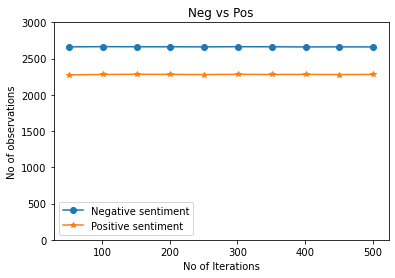

In [59]:
plt.plot(range(51,502,50),neg,label='Negative sentiment',marker='o')
plt.plot(range(51,502,50),pos,label='Positive sentiment',marker='*')
plt.legend()
plt.xlabel('No of Iterations')
plt.ylabel('No of observations')
plt.title("Neg vs Pos")
plt.ylim([0,3000])

From the Above plot the number of negative and positive observation for thier respective iterations is very similar for different number of iterations where the median values of negative messages and positive messages are around 2663 and 2282 respectively  

([<matplotlib.patches.Wedge at 0x2a0b2a4c9d0>,
 [Text(-1.0919538335911279, -0.1328037096832753, 'Negative'),
  Text(1.1912223774819313, 0.1448766626696491, 'Positive')],
 [Text(-0.5956111819587969, -0.07243838709996833, '53.9%'),
  Text(0.6948797201977932, 0.08451138655729529, '46.1%')])

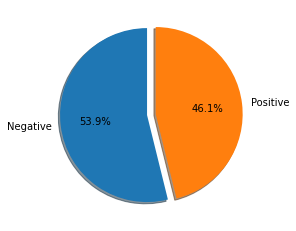

In [75]:
plt.pie([2663,2282],labels=["Negative","Positive"],startangle=90,autopct='%1.1f%%',explode=[0,0.1],shadow=True)

## Conclusion

Analysis on randomly sampled League of Legends Tribunal data shows that approximately 46% of the report recived by the tribunal judgement system is false accusation towards other players and the remaining 54% of messages contained messages with either Verbal Abuse or language of offensive nature. These results may also vary due unpredictalbe presence of
text-patterns,symbols,acronyms,spelling errors and languages with different utf encodings 